To aid autoassociative recall (sparse recall using partial pattern), we need two components -
1. each pattern remembers a soft mask of the contribution of each 
element in activating it. For example, if an element varies a lot at high activation levels, that element should be masked out when determining activation. On the other hand, if an element has a very specific value every time the element has high activation, then that element is important and should be considered (masked-in).
2. Among the masked-in elements for a pattern, even a small subset (say 20%) almost perfect match should be able to activate the pattern. To find soft-perfect match -

mask weighted dim similarity ${s_i}$ will be high only if input value ${x_i}$ is similar to pattern value ${p_i}$ for that dim AND the pattern cares about that dim (i.e. has ~1 mask ${m_i}$)

${s_i = m_i * \lVert x_i, p_i \rVert}$

${s = {1 \over m} \sum s_i}$ is the total mean similarity across dims that the pattern cares about, where

${m = \sum m_i}$ is the soft version of the number of dims that the pattern cares about.



In [1]:
import math
import torch
import matplotlib.pyplot as plt
import pdb
import pandas as pd  
import seaborn as sns 
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d

%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


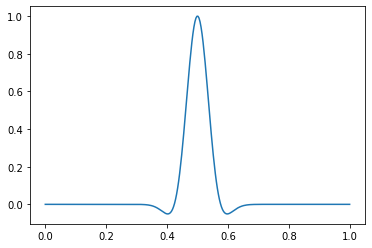

In [2]:
class HP:
  grid_size = 30

  # similarity
  mask_contrast = 3
  mexhat_width = 0.7
  a_max = 1500
  mexhat_inh_width = 0.10   # controls how far away patterns are pushed away by a pattern
  mexhat_inh_scale = 0.85  # controls how strongly patterns push other patterns away

def mexhat(x, patterns, winning_pattern):
  a = HP.mexhat_width * ((x - winning_pattern) ** -2)
  a[a > HP.a_max] = HP.a_max

  sim = (-a * ((x - patterns) ** 2)).mean(dim=-1)
  sim = (torch.exp(sim) - HP.mexhat_inh_scale * torch.exp(sim * (1 - HP.mexhat_inh_width))) / (1 - HP.mexhat_inh_scale)
  sim[sim>1.0] = 1.0
  return sim

def show_mexhat():
  x = torch.linspace(0.0, 1.0, 300)
  sim = mexhat(torch.tensor([0.5]), x.unsqueeze(dim=-1), torch.tensor([0.55]))
  plt.plot(x, sim)
  plt.show()

show_mexhat()

In [3]:
from sklearn.datasets import load_boston
def normalize(df):
  df1 = (df - df.mean())/df.std()
  return df1

def scale(df):
  min = df.min()
  max = df.max()

  df1 = (df - min) / (max - min)
  return df1

dataset = load_boston()
dataset = pd.DataFrame(dataset.data, columns=dataset.feature_names)
dataset = pd.DataFrame(np.c_[scale(normalize(dataset['LSTAT'])), scale(normalize(dataset['RM']))], columns = ['LSTAT','RM'])
dataset = torch.tensor(dataset.to_numpy()).float().to(device)

dataset1 = dataset[dataset[:,0] < 0.33]
dataset2 = dataset[(dataset[:,0] >= 0.33) & (dataset[:,0] < 0.66)]
dataset3 = dataset[dataset[:,0] >= 0.66]

# dataset = [[0.25, 0.4], [0.75, 0.75], [0.85, 0.65]]
original_dataset = dataset
print("dataset", dataset.shape)


dataset torch.Size([506, 2])


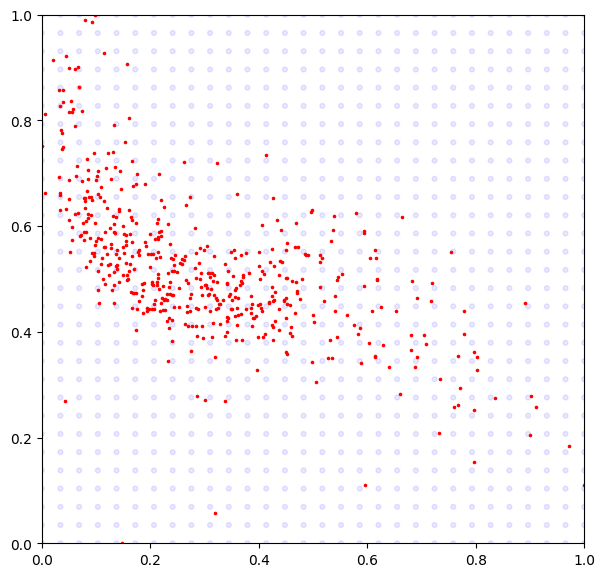

In [4]:
# from https://kornia.readthedocs.io/en/latest/_modules/kornia/utils/grid.html
from typing import Optional

def create_meshgrid(
        height: int,
        width: int,
        normalized_coordinates: Optional[bool] = True,
        device: Optional[torch.device] = torch.device('cpu')) -> torch.Tensor:
    """Generates a coordinate grid for an image.

    When the flag `normalized_coordinates` is set to True, the grid is
    normalized to be in the range [-1,1] to be consistent with the pytorch
    function grid_sample.
    http://pytorch.org/docs/master/nn.html#torch.nn.functional.grid_sample

    Args:
        height (int): the image height (rows).
        width (int): the image width (cols).
        normalized_coordinates (Optional[bool]): whether to normalize
          coordinates in the range [-1, 1] in order to be consistent with the
          PyTorch function grid_sample.

    Return:
        torch.Tensor: returns a grid tensor with shape :math:`(1, H, W, 2)`.
    """
    # generate coordinates
    xs: Optional[torch.Tensor] = None
    ys: Optional[torch.Tensor] = None
    if normalized_coordinates:
        xs = torch.linspace(-1, 1, width, device=device, dtype=torch.float)
        ys = torch.linspace(-1, 1, height, device=device, dtype=torch.float)
    else:
        xs = torch.linspace(0, width - 1, width, device=device, dtype=torch.float)
        ys = torch.linspace(0, height - 1, height, device=device, dtype=torch.float)
    # generate grid by stacking coordinates
    base_grid: torch.Tensor = torch.stack(
        torch.meshgrid([xs, ys])).transpose(1, 2)  # 2xHxW
    return torch.unsqueeze(base_grid, dim=0).permute(0, 2, 3, 1)  # 1xHxWx2

def add_gaussian_noise(tensor, mean=0., std=1.):
    t = tensor + torch.randn(tensor.size()).to(device) * std + mean
    t.to(device)
    return t

def plot_patterns(patterns, pattern_lr, dataset, voronoi=False, annotate=False, figsize=(7,7), dpi=100):
  patterns = patterns.cpu()
  dataset = dataset.cpu()
  assert len(patterns.shape) == 2 # (pattern count, 2)
  assert patterns.shape[1] == 2 # 2D

  rgba_colors = torch.zeros((patterns.shape[0], 4))

  # for blue the last column needs to be one
  rgba_colors[:,2] = 1.0
  # the fourth column needs to be your alphas
  alpha = (1.1 - pattern_lr.cpu()).clamp(0, 1) * 0.9
  rgba_colors[:, 3] = alpha

  plt.figure(figsize=figsize, dpi=dpi)
  ax = plt.gca()
  ax.cla() # clear things for fresh plot

  if annotate:
    for i in range(patterns.shape[0]):
      ax.annotate(str(i), (patterns[i][0], patterns[i][1]), xytext=(5,-3), textcoords='offset points')

  ax.scatter(patterns[:, 0], patterns[:, 1], marker='.', c=rgba_colors, s=50)
  ax.scatter(dataset[:, 0], dataset[:, 1], marker='.', c='r', s=10)

  if voronoi:
    vor = Voronoi(patterns)
    vor_fig = voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='gray',
                              line_width=1, line_alpha=0.2, point_size=0)

  ax.set_xlim(0, 1)
  ax.set_ylim(0, 1)
  plt.show()


grid_size = HP.grid_size
patterns = create_meshgrid(grid_size, grid_size, normalized_coordinates=False).reshape(-1, 2) / (grid_size-1)
patterns = patterns.to(device)
pattern_lr = torch.ones((patterns.shape[0],)).to(device)
pattern_var = torch.ones_like(patterns).to(device) * 10   # start with high var indicating no specificity to any value

# patterns = torch.rand((50, 2))

# patterns = torch.tensor([[0.25, 0.30]])

# patterns
if grid_size < 10:
  plot_patterns(patterns, pattern_lr, dataset, voronoi=True, annotate=True)
else:
  plot_patterns(patterns, pattern_lr, dataset, voronoi=False, annotate=False)

original_patterns = patterns.clone().to(device)

In [0]:
def similarity(x, patterns, pattern_var, grid_size):
  # Formula derivation https://www.desmos.com/calculator/iokn9kyuaq
  # print("x", x)
  mask = torch.exp(-pattern_var * HP.mask_contrast) # *3 so that var of 1 gives low enough mask value ~0.5. Thus mask range [0.5,1]
  dist_i = (x - patterns).abs()
  di = (dist_i ** 2) * mask  # distance weighted by importance
  dist = di.sum(dim=-1) / mask.sum(dim=-1) # dividing by mask sum ~= count of # of dims the pattern cares about
  # print("patterns", patterns)
  # print("dist", dist)
  winner_index = dist.min(dim=0)[1]
  # print("winner_index", winner_index)

  winning_pattern = patterns[winner_index]
  # print("winning_pattern", winning_pattern)

  sim = mexhat(x, patterns, winning_pattern)

  # print("sim", sim)

  return sim, winner_index, dist, dist_i

# sim, winner_index, dist, dist_i = similarity(dataset[0], patterns)

Iteration  0


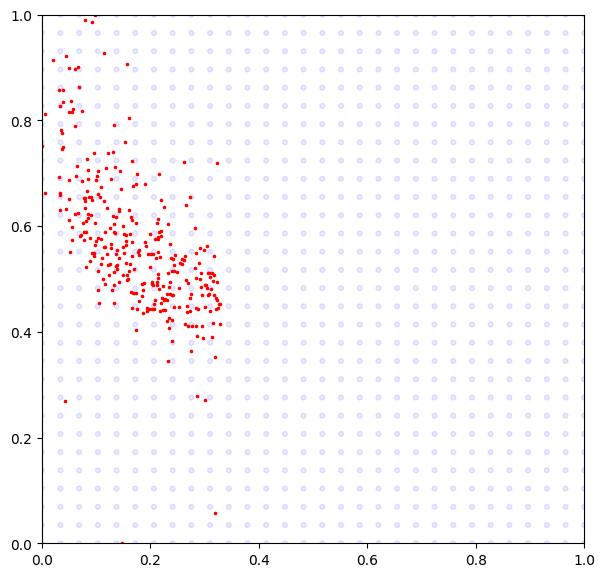

Iteration  0


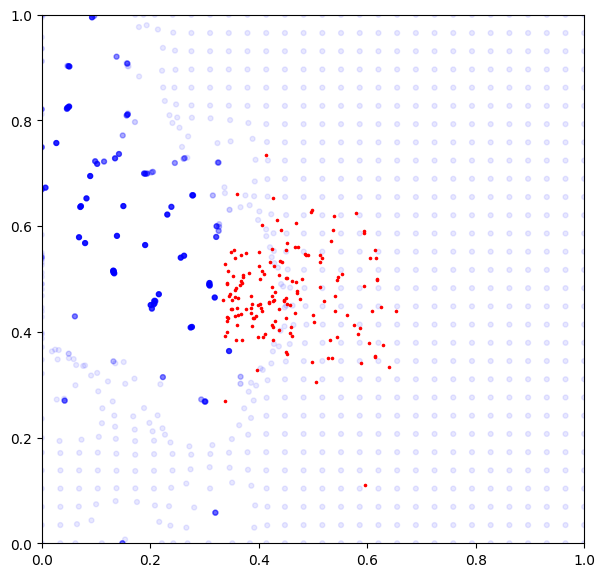

Iteration  0


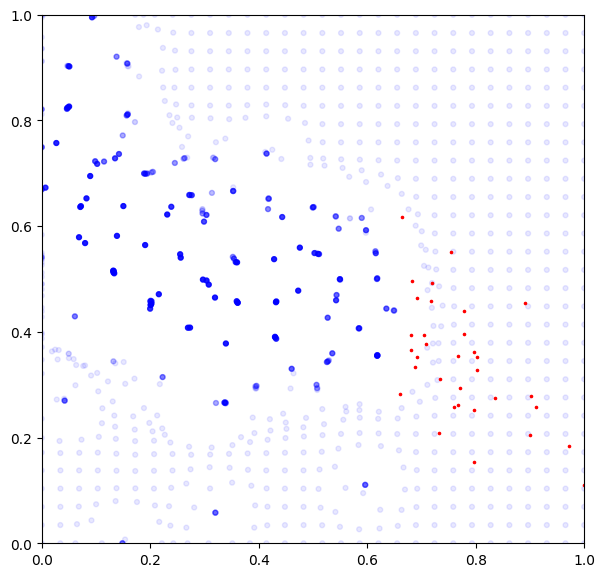

Iteration  0


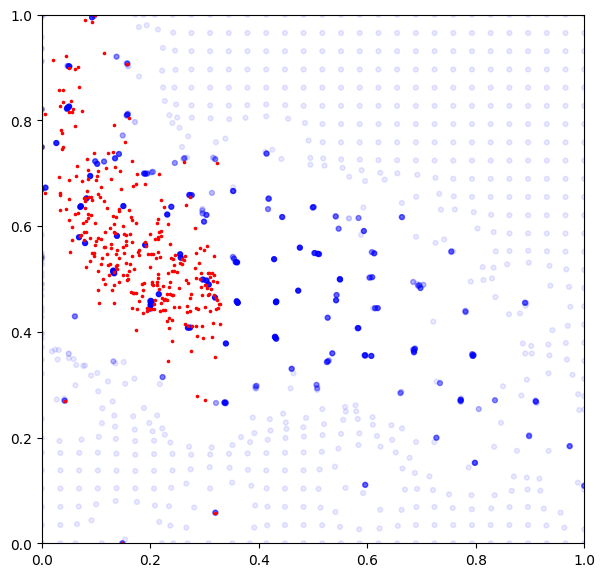

Iteration  0


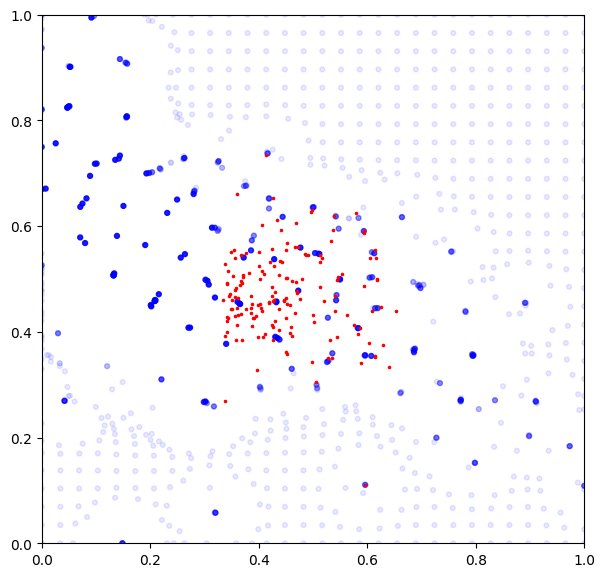

Iteration  0


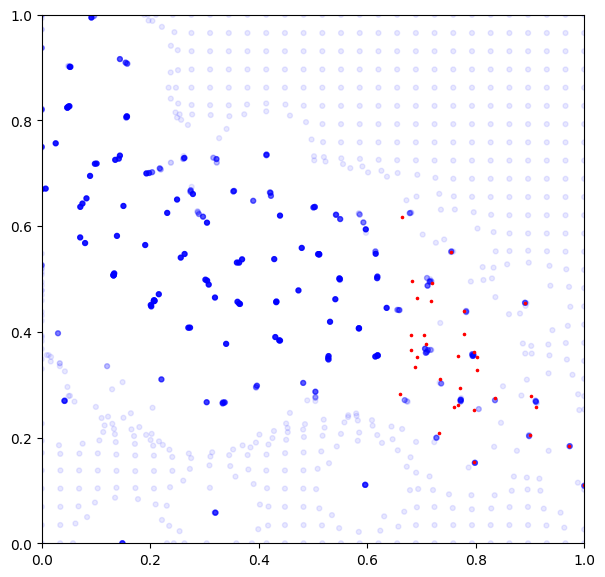

In [8]:
patterns = original_patterns
pattern_lr = torch.ones((patterns.shape[0],)).to(device)
pattern_var = torch.ones_like(patterns).to(device) * 1.0

def run_dataset(dataset, patterns, pattern_lr):
  # print("pattern_var", pattern_var)
  for x in dataset:
    # print("-------")
    sim, winner_index, dist, dist_i = similarity(x=x, patterns=patterns, pattern_var=pattern_var, grid_size=grid_size)
    sim = sim.unsqueeze(-1)
    # print("dist[winner_index]", dist[winner_index] * 100)
    pattern_lr[winner_index] = 0.9 * pattern_lr[winner_index] + 0.1 * (1.0 - torch.exp(-dist[winner_index]))
    pattern_var[winner_index] = 0.9 * pattern_var[winner_index] + 0.1 * dist_i[winner_index]
    # if winner_index == 0:
    #   print("dist_i[winner_index]", dist_i[winner_index])
    #   print("pattern_var[winner_index]", pattern_var[winner_index])

    # print("x", x)
    # print("(x - patterns)", (x - patterns))
    # print("sim", sim)
    delta = (x - patterns) * sim * lr * pattern_lr.unsqueeze(-1)
    # print("delta", delta)
    patterns = patterns + delta

  patterns.clamp_(0, 1)
  pattern_lr.clamp(0, 1)
  # print("patterns", patterns)
  # print("pattern_lr", pattern_lr)
  return patterns, pattern_lr

lr = 1
epochs = 5
noise = 0.0
non_iid = True
if non_iid:
  for _ in range(2):
    for i in range(epochs):
      dataset = add_gaussian_noise(dataset1, std=noise)
      if i % int(epochs / 1) == 0:
        print("Iteration ", i)
        plot_patterns(patterns, pattern_lr, dataset)
      patterns, pattern_lr = run_dataset(dataset, patterns, pattern_lr)

    for i in range(epochs):
      dataset = add_gaussian_noise(dataset2, std=noise)
      if i % int(epochs / 1) == 0:
        print("Iteration ", i)
        plot_patterns(patterns, pattern_lr, dataset)
      patterns, pattern_lr = run_dataset(dataset, patterns, pattern_lr)

    for i in range(epochs):
      dataset = add_gaussian_noise(dataset3, std=noise)
      if i % int(epochs / 1) == 0:
        print("Iteration ", i)
        plot_patterns(patterns, pattern_lr, dataset)
      patterns, pattern_lr = run_dataset(dataset, patterns, pattern_lr)
else:
    for i in range(epochs):
      dataset = add_gaussian_noise(original_dataset, std=noise)
      if i % int(epochs / 1) == 0:
        print("Iteration ", i)
        plot_patterns(patterns, pattern_lr, dataset)
      patterns, pattern_lr = run_dataset(dataset, patterns, pattern_lr)


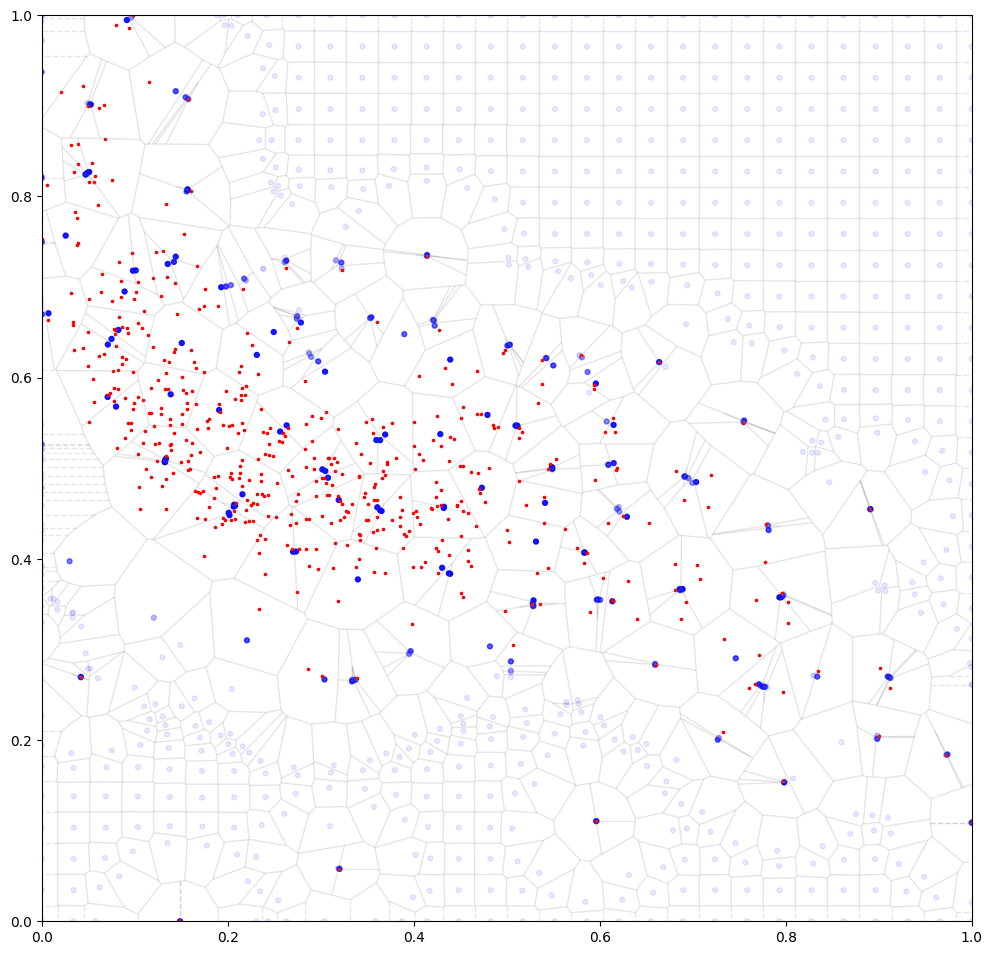

In [9]:
plot_patterns(patterns, pattern_lr, original_dataset, voronoi=True, annotate=False, figsize=(12,12))

Notes -

- 